# End to End Time Series and Forecasting Project

In this notebook, we will discuss how to solve a problem using time series analysis and forecasting. The case is that we want to predict the number of unique visitors into a landing page.

## The Data

You've been provided the data on the slide. Please check out the data, download and upload into google colab storage.

In [ ]:
import pandas as pd #We still need Pandas to load and manipulate the data
import matplotlib.pyplot as plt #Library for create data visualization -> we'll discuss further later on the next week

In [ ]:
data = pd.read_csv('daily-website-visitors.csv.xls')
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


We can see from this (data.info()) that there are no missing values and there are inconsistencies on the data type. Date should be in `datetime64[ns]` instead of object, and Unique.Visits should be in integer instead of object.

## Data Cleaning

In [ ]:
data['Date'] = data['Date'].astype('datetime64[ns]') #Change the datatype into datetime
data['Unique.Visits']  = data['Unique.Visits'].str.replace(',', '').astype('int') #Replace comma into empty space and directly convert the column into integer
data = data.set_index('Date') #This step is important in time series. Date column has to be index
data

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146",1582,"1,430",152
2014-09-15,2,Monday,2,"3,621",2528,"2,297",231
2014-09-16,3,Tuesday,3,"3,698",2630,"2,352",278
2014-09-17,4,Wednesday,4,"3,667",2614,"2,327",287
2014-09-18,5,Thursday,5,"3,316",2366,"2,130",236
...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,"2,221",1696,"1,373",323
2020-08-16,2164,Sunday,1,"2,724",2037,"1,686",351
2020-08-17,2165,Monday,2,"3,456",2638,"2,181",457


Column date has already setted to be dataframe index and `Unique.Visits` has been changed into integer.

<Axes: xlabel='Date'>

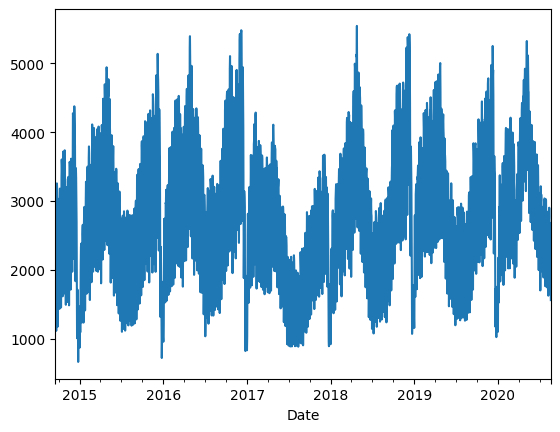

In [ ]:
data['Unique.Visits'].plot()

You can see that in our data, it has wave-like pattern which the recurring period in the big picture is a year (365 days). However, we need to make sure the recurring pattern (seasonal) period is a year, maybe we will find that the period is not 365 days.

### Time Series Decomposition

In this section, we will perform the time series decomposition in order to extract trend and seasonal(main goal). After this step, we will get some insights such as the trend, maximum time, minimum time, and period.

To decompose a time series data, we have to set the model. To begin, we set model with 'additive model'. Then, we evaluate the result based on the residual.

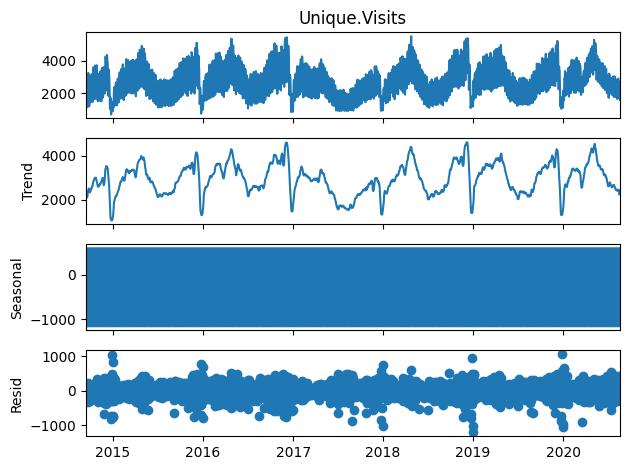

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['Unique.Visits'], model='additive')
ax=res.plot()
plt.show()

The seasonal pattern seems in very small period, so our assumption that the period will be in a year, it's not correct. However, based on the residual, the range is very wide up to -1000 and 1000. Remember that residual is the same as error.

In [ ]:
#data['Unique.Visits'].asfreq('D') you can add `.asfreq('D') if there is an error or warning regarding frequency data, since our time interval is daily, so we set the freq is D

The residual of additive model is very big, so we need to change into multiplicative model. We expect that the data will fit.

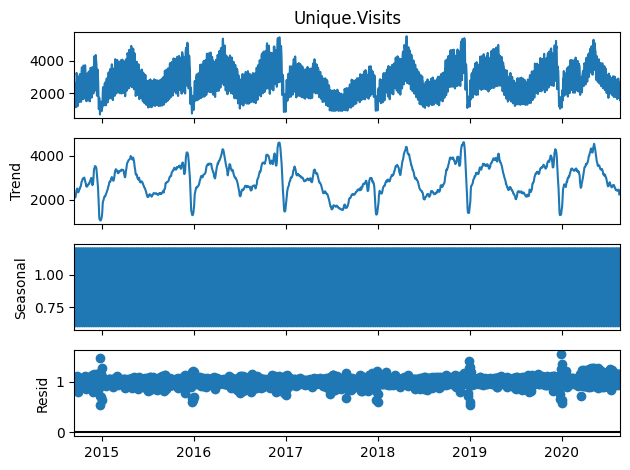

In [ ]:
res = seasonal_decompose(data['Unique.Visits'], model='multiplicative')
ax=res.plot()
plt.show()

Voila! the residual is significantly decreased into 0 - 1 range. So, we will use multiplicative model/

In [ ]:
seasonal_max = res.seasonal[res.seasonal==res.seasonal.max()].reset_index()
seasonal_min = res.seasonal[res.seasonal==res.seasonal.min()].reset_index()
seasonal_max.head()

,Date,seasonal
0,2014-09-16,1.204932
1,2014-09-23,1.204932
2,2014-09-30,1.204932
3,2014-10-07,1.204932
4,2014-10-14,1.204932


In order to find the seasonal period, we extract the seasonal factor only and find the maximum and minimum. We can see below that maximum values happend on every Tuesday and minimum on Saturday.



In [ ]:
seasonal_max['Date'].dt.day_of_week.head() # extract the day of week (Sunday/Monday/etc in a number)
#0= Monday, 6=Sunday

,Date
0,1
1,1
2,1
3,1
4,1


In [ ]:
seasonal_min['Date'].dt.day_of_week.head()

,Date
0,5
1,5
2,5
3,5
4,5


## Stationarity Test

Many time series models assume the data is stationary. To check whether our data is stationary or not, we will use ADF (Augmented Dicky-Fuller) Test.

We evaluate the p-value to determine the stationarity. If p-value is more than 0.05, data is not stationary. Otherwise, if p-value is less than 0.05, data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(data['Unique.Visits'])

ADF Statistic: -4.475969
p-value: 0.000217
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


Data is stationary

### Differencing Technique

We found that our data is stationary. What if the data is not stationary. What will we do? we need to make the data stationary by apply differencing technique. It's very easy and simple to do. We only need to use .diff() method that provided by Pandas.

We will use another data to demonstrate the differencing technique

In [ ]:
passenger=pd.read_csv('https://raw.githubusercontent.com/FTDS-learning-materials/phase-1/master/w3/P1W3D3AM%20-%20Time%20Series%20-%20Part%201%20-%20Air%20Passengers.csv')
passenger

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [ ]:
check_stationarity(passenger['value'])

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Non-stationary


The data is not stationary, so we will apply the differencing to make it's stationary

In [ ]:
diff1 = passenger['value'].diff() # first order differencing
diff1

,value
0,NaN
1,6.0
2,14.0
3,-3.0
4,-8.0
...,...
139,-16.0
140,-98.0
141,-47.0
142,-71.0


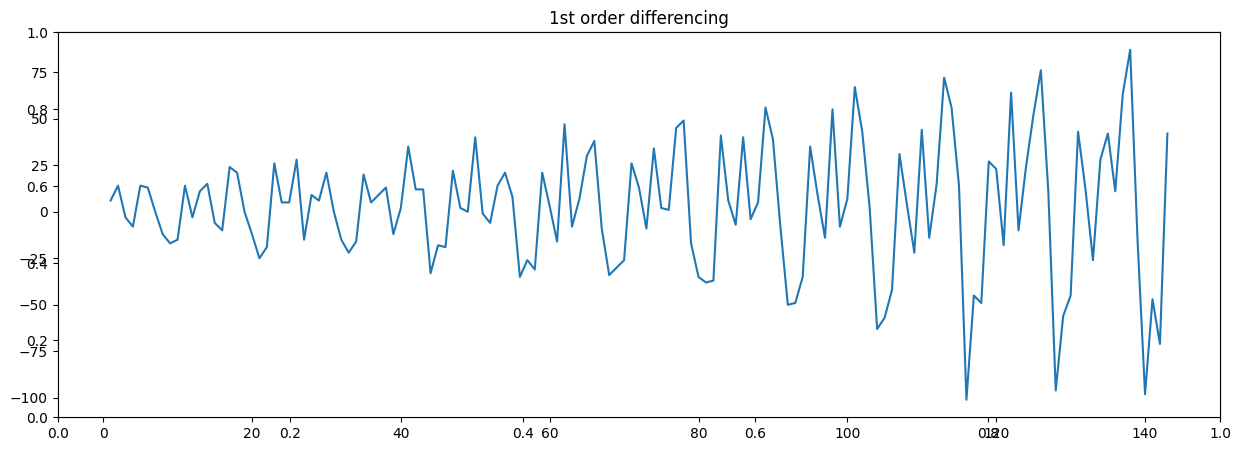

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

Stationary means that there's no trend, and there's no change in variance. However, after we applied the first order differencing, in the later time the variance widened. We expect that the data is still not stationary.

In [ ]:
check_stationarity(diff1.dropna()) # We have to drop the missing values to perform the ADF test.

ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Non-stationary


Yeah, our data still not stationary. Therefore, we need to apply more differencing (second order).

In [ ]:
diff2 = passenger['value'].diff().diff() #second order differencing
diff2

,value
0,NaN
1,NaN
2,8.0
3,-17.0
4,-5.0
...,...
139,-103.0
140,-82.0
141,51.0
142,-24.0


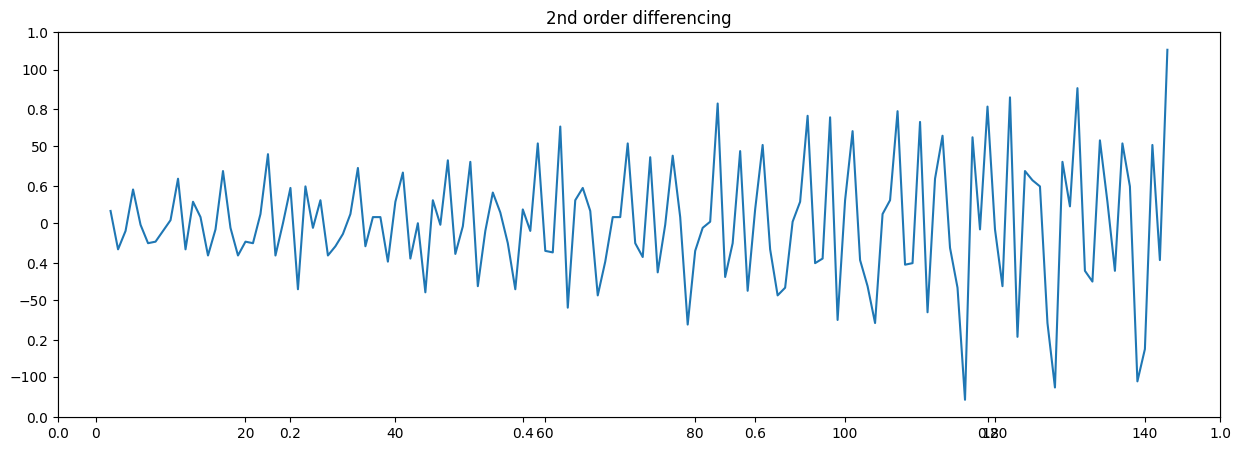

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('2nd order differencing')
ax1.plot(passenger['value'].diff().diff())

On the later time, the variance still increasing but not that wide as previous

In [ ]:
check_stationarity(passenger['value'].diff().diff().dropna())

ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Stationary


The data has been stationary after second order differencing

## ARIMA Model

ARIMA model is a model consist of two models which are autoregressive and moving average. Also, it integrates with differencing factor to handle the non-stationary feature in data.

In training the ARIMA model, we need to set the p, d, and q value. We already find the d value by differencing technique. The data is stationary and doesn't need differencing, so d=0. If we applied first order of differencing, so d=1.

For the first try, we set p=1, d=0, and q=0 and evaluate the model using AIC metric.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data['Unique.Visits'].asfreq('D'), order=(1, 0, 0))
result = model.fit()
print('AIC:',result.aic)

AIC: 34140.122300948286


The AIC is 34140. We dont know the meaning. We need to compare to another model in different parameters combination. But, we still evaluate the model performance by other metrics which are mean squared error and mean absolute error.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MSE:',mean_squared_error(data['Unique.Visits'], result.predict()))
print('MAE:',mean_absolute_error(data['Unique.Visits'], result.predict()))

MSE: 406251.48690030596
MAE: 505.3779208948118


The MSE quite big and the MAE looks so so, which is 505 compare to the range of data. if we forecast the next day is 1500 visitors. So it could be 1000 - 2000 visitors. Moreover, It's still big error.

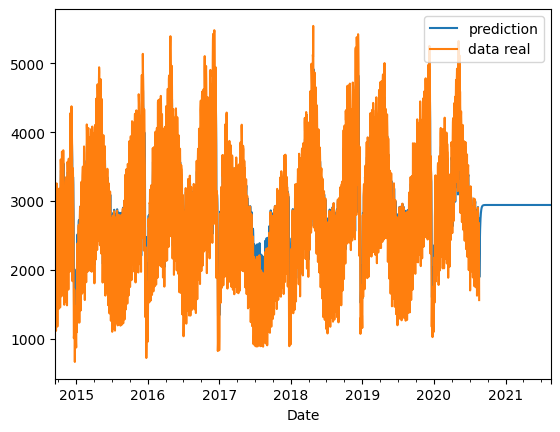

In [ ]:
result.predict(0, len(data)+365).plot(label='prediction')
data['Unique.Visits'].plot(label='data real')
plt.legend()

If we predict the data up to the next 365 days, the data cannot predict the trend in the further days.

However, this is not a good result. We need to find the right combination of p and q.

You can use the function below.

### Fine Tuning

In [ ]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [ ]:
p,d,q,AIC,df = find_best_model(data['Unique.Visits'].asfreq('D'), 10, 0, 10)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning

In [ ]:
df.head()

,p,d,q,AIC
119,10,0,9,29606.741174
108,9,0,9,29609.189682
107,9,0,8,29611.427723
118,10,0,8,29617.325731
120,10,0,10,29617.460657


The best model based on the lowest AIC is a model consist of p=10, d=0, and q=9

In [ ]:
model = ARIMA(data['Unique.Visits'].asfreq('D'), order=(10, 0, 9))
result = model.fit()
print('MSE:',mean_squared_error(data['Unique.Visits'], result.predict()))
print('MAE:',mean_absolute_error(data['Unique.Visits'], result.predict()))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 50035.12480457795
MAE: 162.91985117765006


The MSE and MAE decreased

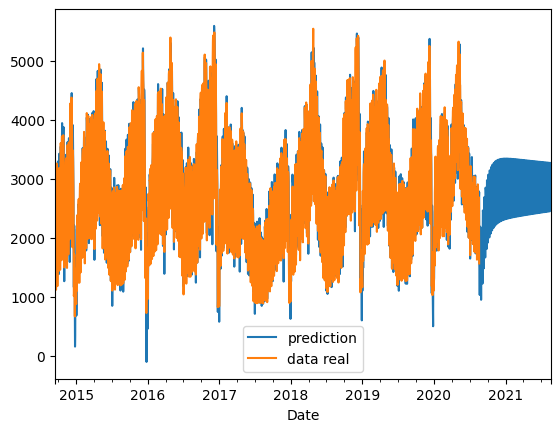

In [31]:
result.predict(0, len(data)+365).plot(label='prediction')
data['Unique.Visits'].plot(label='data real')
plt.legend()

The prediction's pattern is promising

To answer how much daily unique visitors in the next 7 days is predicted below:

In [32]:
result.predict(len(data), len(data)+7)

,predicted_mean
2020-08-20,1593.472893
2020-08-21,1484.145269
2020-08-22,1029.656778
2020-08-23,1494.359850
2020-08-24,2187.289450
2020-08-25,2085.826387
2020-08-26,1827.385480
2020-08-27,1741.641614


Remember, you need to involve the ~163 error. So, on 27 August 2020, unique visitors will be as much 1687 - 1904 visitors.